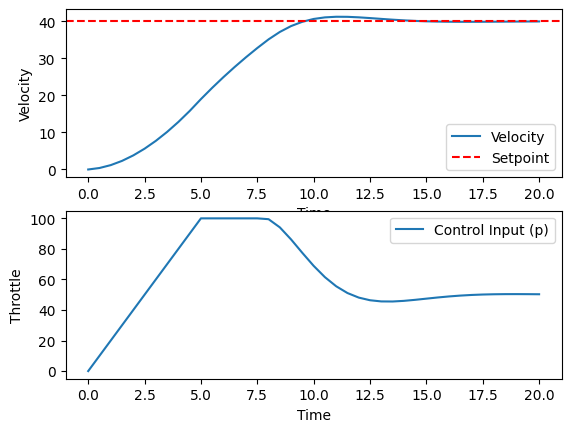

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Time settings
time = np.linspace(0, 20, 41)
dt = time[1] - time[0]

# Constants
mass = 500
b = 50
K = 0.8

# Setpoint
v_sp = 40

# Initial conditions
v = np.zeros_like(time)
p = np.zeros_like(time)  # Ensure initial throttle is 0

# Cost function for MPC
def objective(p_seq, v_curr):
    v_pred = v_curr
    cost = 0
    p_prev = p[i]  # Previous control input
    for p_i in p_seq:
        dv = (-v_pred * b + K * b * p_i) / mass * dt
        v_pred += dv
        cost += (v_pred - v_sp) ** 2  # L2 norm tracking error
        cost += 0.1 * (p_i - p_prev) ** 2  # Penalize large changes in p
        p_prev = p_i
    return cost

# Constraints
bounds = [(0, 100) for _ in range(5)]  # Limit p within [0, 100]

# MPC loop
horizon = 5  # Predictive horizon
for i in range(len(time) - 1):
    res = minimize(objective, np.ones(horizon) * p[i], args=(v[i],), bounds=bounds, method='COBYLA')
    p_new = res.x[0]  # Suggested new control input
    p[i + 1] = np.clip(p[i] + np.clip(p_new - p[i], -10, 10), 0, 100)  # Enforce Δp ≤ 20
    v[i + 1] = v[i] + (-v[i] * b + K * b * p[i + 1]) / mass * dt

# Plot results
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(time, v, label="Velocity")
plt.axhline(y=v_sp, color='r', linestyle='--', label="Setpoint")
plt.xlabel("Time")
plt.ylabel("Velocity")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(time, p, label="Control Input (p)")
plt.xlabel("Time")
plt.ylabel("Throttle")
plt.legend()

plt.show()


In [14]:
import pandas as pd
df = pd.DataFrame({'time': time, 'velocity': v, 'throttle': p})

apm 91.140.77.120_gk_model4 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.3
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            4
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Number of state variables:            360
 Number of total equations: -          320
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :             40
 
 **********************************************
 Dynamic Control with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains Ipop

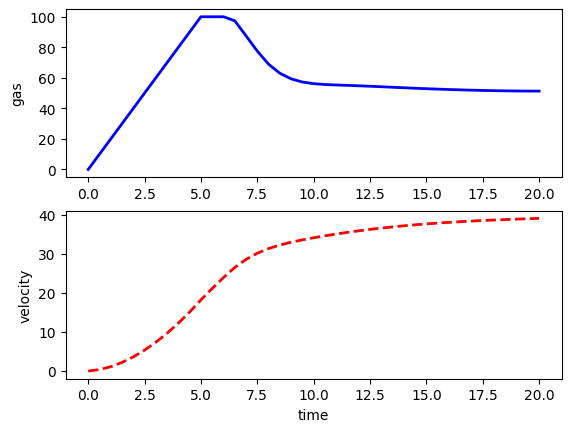

In [15]:
#%%Import packages
import numpy as np
from random import random
from gekko import GEKKO
import matplotlib.pyplot as plt

#%% Build model

#initialize GEKKO model
m = GEKKO()

#time
m.time = np.linspace(0,20,41)

#constants
mass = 500

#Parameters
b = m.Param(value=50)
K = m.Param(value=0.8)
#Manipulated variable
p = m.MV(value=0, lb=0, ub=100)

#Controlled Variable
v = m.CV(value=0)

#Equations
m.Equation(mass*v.dt() == -v*b + K*b*p)

#%% Tuning

#global
m.options.IMODE = 6 #control

#MV tuning
p.STATUS = 1 #allow optimizer to change
p.DCOST = 0.1 #smooth out gas pedal movement
p.DMAX = 10 #slow down change of gas pedal

#CV tuning
#setpoint
v.STATUS = 1 #add the SP to the objective
m.options.CV_TYPE = 2 #L2 norm
v.SP = 40 #set point
v.TR_INIT = 1 #setpoint trajectory
v.TAU = 5 #time constant of setpoint trajectory

#%% Solve

m.solve()

#%% Plot solution
plt.figure()
plt.subplot(2,1,1)
plt.plot(m.time,p.value,'b-',linewidth=2)
plt.ylabel('gas')
plt.subplot(2,1,2)
plt.plot(m.time,v.value,'r--',linewidth=2)
plt.ylabel('velocity')
plt.xlabel('time')
plt.show()

In [18]:
df['velocity_mpc'] = v.value    
df['throttle_mpc'] = p.value
df['vel_diff'] = df['velocity'] - df['velocity_mpc']
df['throttle_diff'] = df['throttle'] - df['throttle_mpc']
df['throttle_diff'].mean()

2.193405859376308